### CSI 4106 - Introduction to Artificial Intelligence - Project W2022

### Simon Paquette - spaqu044@uottawa.ca - 300044038

### Image Colorization


In [1]:
import shutil
import time
from pathlib import Path
from typing import Dict, List, Tuple

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.layers import (
    BatchNormalization,
    Conv2D,
    Input,
    LeakyReLU,
    MaxPooling2D,
    ReLU,
    RepeatVector,
    Reshape,
    UpSampling2D,
    concatenate,
    LayerNormalization,
    Conv2DTranspose,
)
from keras.models import Model, load_model
from sklearn.model_selection import train_test_split

np.random.seed(42)
tf.random.set_seed(42)


In [2]:
# my gpu: GTX1650 4gb
import GPUtil
import os

# see memory use
GPUs = GPUtil.getGPUs()
for i, gpu in enumerate(GPUs):
    print(
        "GPU {:d} ... Mem Free: {:.0f}MB / {:.0f}MB | Utilization {:3.0f}%".format(
            i, gpu.memoryFree, gpu.memoryTotal, gpu.memoryUtil * 100
        )
    )

# use cpu instead of gpu   
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'


GPU 0 ... Mem Free: 3964MB / 4096MB | Utilization   0%


In [3]:
WIDTH = 128
HEIGHT = 128
SIZE = (WIDTH, HEIGHT)
BATCH = 8


def make_dir(name: str) -> Path:
    """
    Create and return directory name

    Args:
        name (str): directory name

    Returns:
        Path: directory name
    """
    path = Path(name)
    if not path.exists():
        path.mkdir()
    return path


IMAGES_DIR = make_dir("images")
DS2_DIR = make_dir("images2")
MODELS_DIR = make_dir("models")
LOGS_DIR = make_dir("logs")
TMP_DIR = make_dir("tmp")

# List of callback to be applied in model.fit()
early_stop = tf.keras.callbacks.EarlyStopping(
    patience=5, restore_best_weights=True, verbose=1
)
checkpoints = tf.keras.callbacks.ModelCheckpoint(
    TMP_DIR.joinpath(str(int(time.time()))), verbose=1
)
tensorboard = tf.keras.callbacks.TensorBoard(LOGS_DIR.joinpath(str(int(time.time()))))
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=2, min_lr=1e-07, verbose=1)

CALLBACKS = [early_stop, checkpoints, tensorboard, reduce_lr]


In [4]:
def del_log_tmp():
    """
    Delete the files within logs folder (tensorboard log) and tmp folder (model checkpoint)
    """
    logs = list(LOGS_DIR.iterdir())
    tmps = list(TMP_DIR.iterdir())
    names = logs + tmps
    for name in names:
        if name.is_dir():
            shutil.rmtree(name)
        elif name.is_file():
            name.unlink()


del_log_tmp()


In [5]:
def preprocess_image(image_path: Path) -> Tuple[np.ndarray, np.ndarray]:
    """
    Open, resize, convert to LAB, and normalize the image

    Args:
        image_path (Path): image to be opened

    Returns:
        Tuple[np.ndarray, np.ndarray]: L channel and AB channel
    """
    image = cv.imread(str(image_path), cv.IMREAD_COLOR)
    image = cv.resize(image, SIZE)
    image = image.astype(np.uint8)
    image = cv.cvtColor(image, cv.COLOR_BGR2LAB)
    image = image.astype(np.float32)
    image /= 255.0
    l, a, b = cv.split(image)
    ab = cv.merge([a, b])
    return (l, ab)


def construct_image(l_channel: np.ndarray, ab_channel: np.ndarray) -> np.ndarray:
    """
    Merge LAB, clip, range value between 0-255, and convert to RGB

    Args:
        l_channel (np.ndarray): L* lightness
        ab_channel (np.ndarray): a* green-red && b* yellow-blue

    Returns:
        np.ndarray: RGB image
    """
    image = cv.merge([l_channel, ab_channel])
    image = np.clip(image, 0, 1)
    image *= 255
    image = image.astype(np.uint8)
    image = cv.cvtColor(image, cv.COLOR_LAB2RGB)
    return image


def load_dataset(directory: Path) -> Tuple:
    """
    Extract features (L channel) and labels (ab channels)

    Args:
        directory (Path): folder with images dataset

    Returns:
        Tuple: x_train, x_test, y_train, y_test
    """
    pathnames = list(directory.iterdir())
    x, y = [], []
    for pathname in pathnames:
        l_channel, ab_channel = preprocess_image(pathname)
        x.append(l_channel)
        y.append(ab_channel)
    features = np.array(x)
    labels = np.array(y)
    # train(70)/val(15)/test(15)
    x_train, x_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.15, random_state=42
    )
    return (x_train, x_test, y_train, y_test)


def plot_images(image_dict: Dict[str, np.ndarray]):
    """
    Show the given images (1-4) side by side.

    Args:
        image_dict (Dict[str, np.ndarray]): title, image
    """

    keys = list(image_dict.keys())
    n = len(image_dict)
    assert n <= 4, "Limit of 4 images side by side"
    fig, images = plt.subplots(1, n)
    inches = 5
    fig.set_size_inches(n * inches, inches)
    if n == 1:
        images = [images]
    for index, im in enumerate(images):
        im.axis("off")
        title = keys[index]
        im.set_title(title)
        image = image_dict[title]
        if image.ndim != 3:
            im.imshow(image, cmap="gray")
        else:
            im.imshow(image)


def create_model_colorization(model_func):
    """
    Define the colorization model

    Args:
        model_func (_type_): a function that create a TF model with different testing layer

    Returns:
        _type_: a TF colorization model with layers
    """
    input_layer = Input(shape=(HEIGHT, WIDTH, 1))
    output_layer = model_func(input_layer)
    model_colorization = Model(inputs=input_layer, outputs=output_layer)
    model_colorization.summary()
    return model_colorization


def train_pipeline(
    model_func, compile_func, fit_func, features: np.ndarray, labels: np.ndarray
):
    """
    A pipeline to apply a training step. A model creation, compilation and fit from training data and labels

    Args:
        model_func (_type_): a function that create a TF model with different testing layers
        compile_func (_type_): a function that compile a TF model with different testing optimizers, losses and metrics
        fit_func (_type_): a function that fit a TF model with different testing parameters like epochs
        data (np.ndarray): training data
        labels (np.ndarray): training labels

    Returns:
        _type_: a trained TF colorization model
    """
    model = create_model_colorization(model_func)
    compile_func(model)
    fit_func(model, features, labels)
    return model


def predict_ab_channel(l_channel: np.ndarray, model) -> np.ndarray:
    """
    Color prediction (ab_channel) from an image (using the grayscale L*) created by the model

    Args:
        l_channel (np.ndarray): input
        model (_type_): a TF model for colorization

    Returns:
        np.ndarray: a new predicted ab channel
    """
    grayscale = l_channel.reshape(1, HEIGHT, WIDTH, 1)
    ab_prediction = model.predict(grayscale, batch_size=BATCH)
    ab_prediction = ab_prediction.reshape(HEIGHT, WIDTH, 2)
    return ab_prediction


def test_eval(model, features: np.ndarray, labels: np.ndarray):
    """
    Evaluate the model with testing data and labels

    Args:
        model (_type_): a trained TF colorization model
        features (np.ndarray): testing features
        labels (np.ndarray): testing labels
    """
    model.evaluate(features, labels, batch_size=BATCH)


def save_my_model(model, name: str):
    """
    Save a model into the folder MODELS_DIR

    Args:
        model (_type_): a trained model
        name (str): model name
    """
    model.save(f"{MODELS_DIR}/{name}.h5")


def load_my_model(name: str):
    """
    Load a model from the folder MODELS_DIR

    Args:
        name (str): model name

    Returns:
        _type_: a trained model
    """
    model = load_model(f"{MODELS_DIR}/{name}.h5")
    return model


def print_np_arr(arr):
    with np.printoptions(threshold=np.inf):
        print(arr)


In [6]:
def model_classic(input_layer):
    model = Conv2D(16, (3, 3), padding="same", strides=1)(input_layer)
    model = LeakyReLU()(model)
    # model = Conv2D(64,(3,3), activation='relu',strides=1)(model)
    model = Conv2D(32, (3, 3), padding="same", strides=1)(model)
    model = LeakyReLU()(model)
    model = BatchNormalization()(model)
    model = MaxPooling2D(pool_size=(2, 2), padding="same")(model)
    model = Conv2D(64, (3, 3), padding="same", strides=1)(model)
    model = LeakyReLU()(model)
    model = BatchNormalization()(model)
    model = MaxPooling2D(pool_size=(2, 2), padding="same")(model)
    model = Conv2D(128, (3, 3), padding="same", strides=1)(model)
    model = LeakyReLU()(model)
    model = BatchNormalization()(model)
    model = Conv2D(256, (3, 3), padding="same", strides=1)(model)
    model = LeakyReLU()(model)
    model = BatchNormalization()(model)
    model = UpSampling2D((2, 2))(model)
    model = Conv2D(128, (3, 3), padding="same", strides=1)(model)
    model = LeakyReLU()(model)
    model = BatchNormalization()(model)
    model = UpSampling2D((2, 2))(model)
    model = Conv2D(64, (3, 3), padding="same", strides=1)(model)
    model = LeakyReLU()(model)
    # model = BatchNormalization()(model)
    concat_ = concatenate([model, input_layer])
    model = Conv2D(64, (3, 3), padding="same", strides=1)(concat_)
    model = LeakyReLU()(model)
    model = BatchNormalization()(model)
    model = Conv2D(32, (3, 3), padding="same", strides=1)(model)
    model = LeakyReLU()(model)
    # model = BatchNormalization()(model)
    model = Conv2D(2, (3, 3), activation="tanh", padding="same", strides=1)(model)
    return model


def model_basic(input_layer):
    model = Conv2D(16, (3, 3), activation="relu", padding="same", strides=1)(
        input_layer
    )
    model = Conv2D(32, (3, 3), activation="relu", padding="same", strides=1)(model)
    model = Conv2D(64, (3, 3), activation="relu", padding="same", strides=1)(model)
    model = Conv2D(32, (3, 3), activation="relu", padding="same", strides=1)(model)
    model = Conv2D(16, (3, 3), activation="relu", padding="same", strides=1)(model)
    model = Conv2D(2, (3, 3), activation="relu", padding="same", strides=1)(model)
    return model


def model_conv_sampling(input_layer):
    model = Conv2D(64, (3, 3), activation="relu", padding="same")(input_layer)
    model = Conv2D(64, (3, 3), activation="relu", padding="same", strides=2)(model)
    model = Conv2D(128, (3, 3), activation="relu", padding="same")(model)
    model = Conv2D(128, (3, 3), activation="relu", padding="same", strides=2)(model)
    model = Conv2D(256, (3, 3), activation="relu", padding="same")(model)
    model = Conv2D(256, (3, 3), activation="relu", padding="same", strides=2)(model)
    model = Conv2D(512, (3, 3), activation="relu", padding="same")(model)
    model = Conv2D(256, (3, 3), activation="relu", padding="same")(model)
    model = Conv2D(128, (3, 3), activation="relu", padding="same")(model)
    model = UpSampling2D((2, 2))(model)
    model = Conv2D(64, (3, 3), activation="relu", padding="same")(model)
    model = UpSampling2D((2, 2))(model)
    model = Conv2D(32, (3, 3), activation="relu", padding="same")(model)
    model = Conv2D(2, (3, 3), activation="relu", padding="same")(model)
    model = UpSampling2D((2, 2))(model)
    return model

def model_large_kernel_regularizer(input_layer):
    model = Conv2D(64, (11, 11), activation="relu", kernel_regularizer="L1", padding="same")(input_layer)
    model = Conv2D(128, (7, 7), activation="relu", strides=2, padding="same")(model)
    model = BatchNormalization()(model)
    
    model = Conv2D(256, (5, 5), activation="relu", kernel_regularizer="L1", padding="same")(model)
    model = Conv2D(512, (3, 3), activation="relu", strides=2, padding="same")(model)
    model = BatchNormalization()(model)
    
    model = UpSampling2D((2, 2))(model)
    model = Conv2D(64, (3, 3), activation="relu", padding="same")(model)
    model = BatchNormalization()(model)
    
    model = UpSampling2D((2, 2))(model)
    model = Conv2D(64, (3, 3), activation="relu", padding="same")(model)
    model = BatchNormalization()(model)
    
    model = Conv2D(2, (3, 3), activation="relu", padding="same")(model)
    return model

def model_RichardZhang(input_layer):
    #problem out of memory
    model = Conv2D(filters=64,kernel_size=3,strides=1,padding="same",dilation_rate=1,activation="relu")(input_layer)
    model = Conv2D(filters=64,kernel_size=3,strides=2,padding="same",dilation_rate=1,activation="relu")(model)
    model = BatchNormalization()(model)
    
    model = Conv2D(filters=128,kernel_size=3,strides=1,padding="same",dilation_rate=1,activation="relu")(model)
    model = Conv2D(filters=128,kernel_size=3,strides=2,padding="same",dilation_rate=1,activation="relu")(model)
    model = BatchNormalization()(model)
    
    model = Conv2D(filters=256,kernel_size=3,strides=1,padding="same",dilation_rate=1,activation="relu")(model)
    model = Conv2D(filters=256,kernel_size=3,strides=1,padding="same",dilation_rate=1,activation="relu")(model)
    model = Conv2D(filters=256,kernel_size=3,strides=2,padding="same",dilation_rate=1,activation="relu")(model)
    model = BatchNormalization()(model)
    
    # model = Conv2D(filters=512,kernel_size=3,strides=1,padding="same",dilation_rate=1,activation="relu")(model)
    # model = Conv2D(filters=512,kernel_size=3,strides=1,padding="same",dilation_rate=1,activation="relu")(model)
    # model = Conv2D(filters=512,kernel_size=3,strides=1,padding="same",dilation_rate=1,activation="relu")(model)
    # model = LayerNormalization()(model)
    
    #filtes=512
    model = Conv2D(filters=256,kernel_size=3,strides=1,padding="same",dilation_rate=2,activation="relu")(model)
    model = Conv2D(filters=256,kernel_size=3,strides=1,padding="same",dilation_rate=2,activation="relu")(model)
    model = Conv2D(filters=512,kernel_size=3,strides=1,padding="same",dilation_rate=2,activation="relu")(model)
    model = BatchNormalization()(model)
    
    #filtes=512
    model = Conv2D(filters=256,kernel_size=3,strides=1,padding="same",dilation_rate=2,activation="relu")(model)
    model = Conv2D(filters=256,kernel_size=3,strides=1,padding="same",dilation_rate=2,activation="relu")(model)
    model = Conv2D(filters=256,kernel_size=3,strides=1,padding="same",dilation_rate=2,activation="relu")(model)
    model = BatchNormalization()(model)
    
    #filtes=512
    model = Conv2D(filters=256,kernel_size=3,strides=1,padding="same",dilation_rate=1,activation="relu")(model)
    model = Conv2D(filters=256,kernel_size=3,strides=1,padding="same",dilation_rate=1,activation="relu")(model)
    model = Conv2D(filters=256,kernel_size=3,strides=1,padding="same",dilation_rate=1,activation="relu")(model)
    model = BatchNormalization()(model)
    
    model = Conv2DTranspose(filters=256,kernel_size=4,strides=2,padding="same",dilation_rate=1,activation="relu")(model)
    model = Conv2D(filters=256,kernel_size=3,strides=1,padding="same",dilation_rate=1,activation="relu")(model)
    model = Conv2D(filters=256,kernel_size=3,strides=1,padding="same",dilation_rate=1,activation="relu")(model)
    #model = Conv2D(filters=313,kernel_size=1,strides=1,padding="same",dilation_rate=1,activation="softmax")(model)
    model = Conv2D(filters=2,kernel_size=1,strides=1,padding="same",dilation_rate=1,activation="sigmoid")(model)
    model = UpSampling2D(size=4, interpolation='bilinear')(model)
    return model

def model_split_learning(input_layer):
    
    #shared
    model = Conv2D(filters=128,kernel_size=3,strides=1,padding="same",activation="relu")(input_layer)
    model = Conv2D(filters=128,kernel_size=3,strides=2,padding="same",activation="relu")(model)
    model = BatchNormalization()(model)
    model = Conv2D(filters=256,kernel_size=3,strides=1,padding="same",activation="relu")(model)
    model = Conv2D(filters=256,kernel_size=3,strides=2,padding="same",activation="relu")(model)
    model = BatchNormalization()(model)
    
    #a
    a = Conv2D(filters=64,kernel_size=3,strides=1,padding="same",activation="relu")(model)
    a = UpSampling2D(2)(a)
    a = Conv2D(filters=64,kernel_size=3,strides=1,padding="same",activation="relu")(a)
    a = UpSampling2D(2)(a)
    
    #b
    b = Conv2D(filters=64,kernel_size=3,strides=1,padding="same",activation="relu")(model)
    b = UpSampling2D(2)(b)
    b = Conv2D(filters=64,kernel_size=3,strides=1,padding="same",activation="relu")(b)
    b = UpSampling2D(2)(b)
    
    model = concatenate([a, b])
    model = Conv2D(2, (3, 3), activation="relu", padding="same")(model)
    return model
    

def compile_adam_mse(model):
    model.compile(optimizer="adam", loss="mse", metrics=["mae", "mse", "accuracy"])


def compile_adam_mae(model):
    model.compile(optimizer="adam", loss="mae", metrics=["mae", "mse", "accuracy"])


def compile_rmsprop_mse(model):
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae", "mse", "accuracy"])


def compile_rmsprop_mae(model):
    model.compile(optimizer="rmsprop", loss="mae", metrics=["mae", "mse", "accuracy"])
    

def fit_callbacks(model, features, labels):
    # train(70)/val(15)/test(15)
    model.fit(
        features,
        labels,
        epochs=30,
        validation_split=0.15,
        batch_size=BATCH,
        callbacks=CALLBACKS,
    )

def fit_test(model, features, labels):
    model.fit(
        features,
        labels,
        epochs=2,
        validation_split=0.15,
        batch_size=BATCH,
    )

In [7]:
# Get training and testing dataset from "./images"
x_train, x_test, y_train, y_test = load_dataset(IMAGES_DIR)


#new dataset https://www.kaggle.com/datasets/duttadebadri/image-classification
#x_train, x_test, y_train, y_test = load_dataset(DS2_DIR)


In [8]:
# Model parameters
model_name = "LargeKernelRegularizer"
model_layers = model_large_kernel_regularizer
model_compile = compile_adam_mae
model_fit = fit_callbacks

# Model construction
model = train_pipeline(model_layers, model_compile, model_fit, x_train, y_train)
save_my_model(model, model_name)
print("\n\nTEST\n----")
test_eval(model, x_test, y_test)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      7808      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       401536    
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 256)       819456    
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 512)       1180160   
                                                             

| loss E-4 (train/val/test) | adam_mse | adam_mae    | rmsprop_mse | rmsprop_mae |
| ------------------------- | -------- | ----------- | ----------- | ----------- |
| basic                     | 23/22/22 | 312/308/303 | 22/22/21    | 306/303/298 |
| classic                   | 21/20/19 | 301/290/287 | 22/20/20    | 303/290/286 |
| conv_sampling             | 19/19/19 | 252/292/288 | 19/19/19    | 363/359/349 |

generally between 20 and 25 epochs

MSE vs MAE -> hard to say which is best. MAE sometime create false color, but produce more vibrant colors. MSE is stable but more grayish image (unsaturated)

ADAM vs RMSPROP -> ADAM, similar, but adam detect more specific details. May need to test both sometimes. adam loss may have 1-2 higher loss, but is more stable for each algorithm

tried SGD optimizer, really bad result

Problems: blue and green colors are favorised, probably because landscape image have more of those colors (unbalanced data)

Richardzhang.h5 only gray images..

Split learning: loss: 0.0339 - mae: 0.0339 - mse: 0.0028 - val_loss: 0.0333 - val_mae: 0.0333 - val_mse: 0.0027

Split learning rmsprop: loss: 0.0304 - mae: 0.0304 - mse: 0.0021 - accuracy: 0.6798 - val_loss: 0.0298 - val_mae: 0.0298 - val_mse: 0.0021 - val_accuracy: 0.6824

LargeKernelRegul.: loss: 0.0343 - mae: 0.0340 - mse: 0.0028 - accuracy: 0.6073

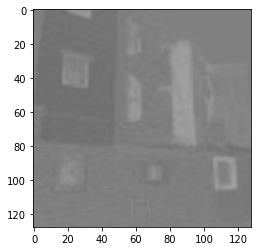

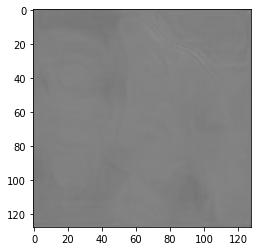

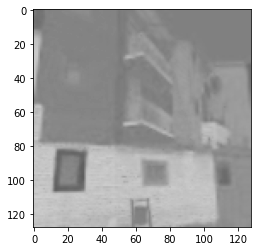

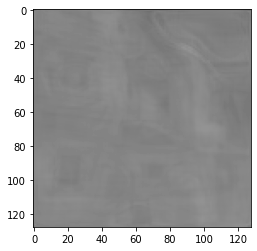

In [17]:
#lab color
image_path = Path(IMAGES_DIR, "1.jpg")
l_channel, ab_channel = preprocess_image(image_path)
a, b = cv.split(ab_channel)
new_ab_channel = predict_ab_channel(l_channel, load_my_model("classic_adam_mse"))
new_a, new_b = cv.split(new_ab_channel)
plt.imshow(a, vmin=0, vmax=1, cmap="gray")
plt.show()
plt.imshow(new_a, vmin=0, vmax=1, cmap="gray")
#print_np_arr(new_a)
plt.show()
plt.imshow(b, vmin=0, vmax=1, cmap="gray")
plt.show()
plt.imshow(new_b, vmin=0, vmax=1, cmap="gray")
plt.show()

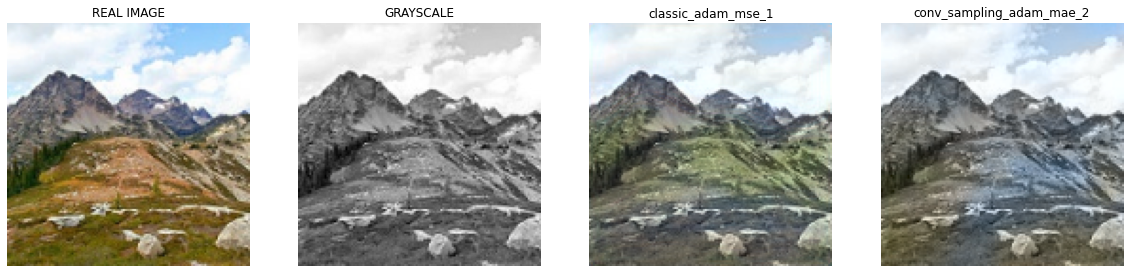

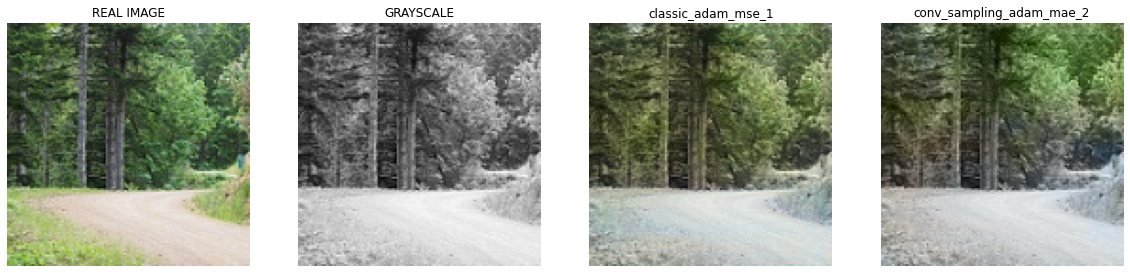

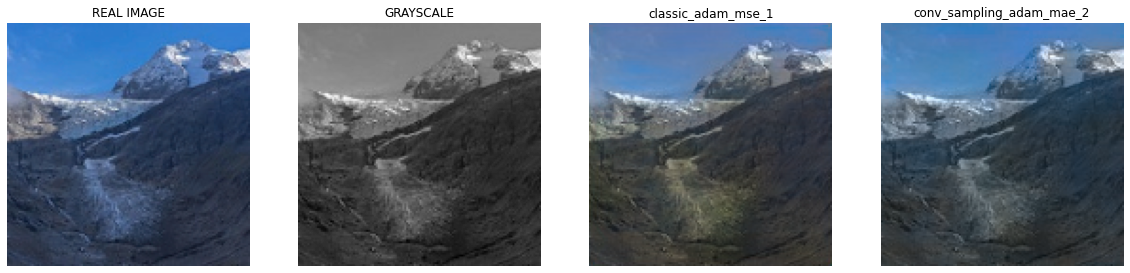

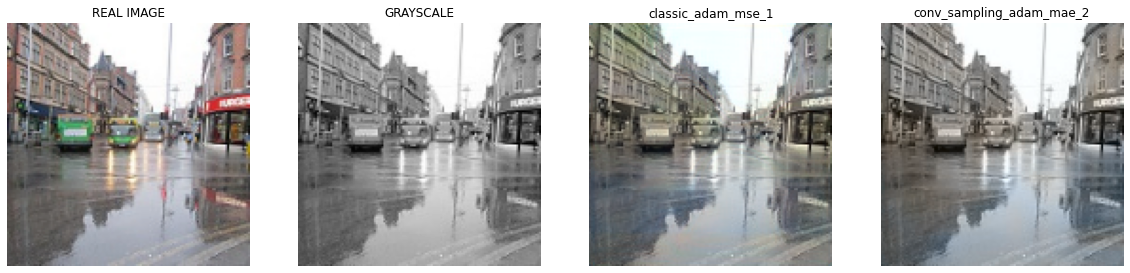

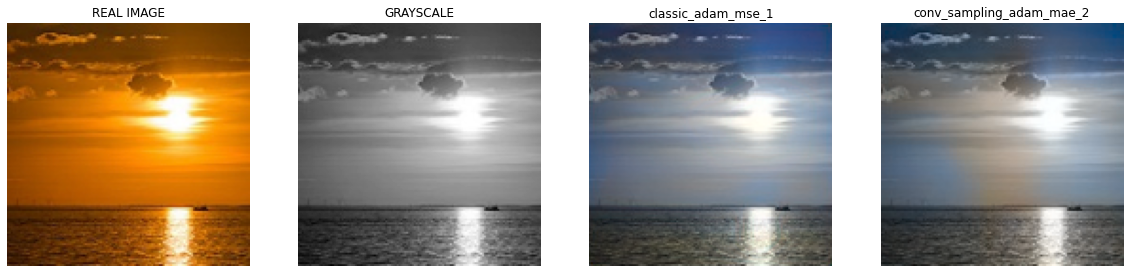

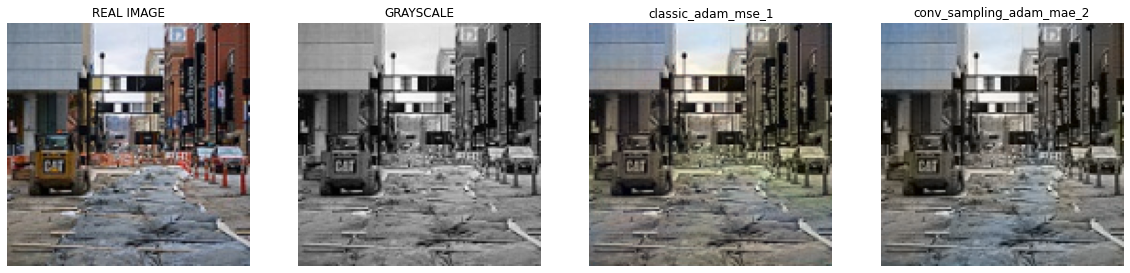

In [28]:
# Show some results images
START = 121
N_IMAGES = 6
name_1 = "classic_adam_mse"
name_2 = "conv_sampling_adam_mae"

for n_jpg in range(START, START + N_IMAGES):
    image_path = Path(IMAGES_DIR, f"{n_jpg}.jpg")
    #image_path = Path(DS2_DIR, f"Places365_val_0000{n_jpg+5731}.jpg")
    
    
    model_1 = load_my_model(name_1)
    model_2 = load_my_model(name_2)
    
    l_channel, ab_channel = preprocess_image(image_path)
    original_image = construct_image(l_channel, ab_channel)
    
    new_ab_channel = predict_ab_channel(l_channel, model_1)
    new_image_1 = construct_image(l_channel, new_ab_channel)
    
    new_ab_channel = predict_ab_channel(l_channel, model_2)
    new_image_2 = construct_image(l_channel, new_ab_channel)
    
    im_show = {
        "REAL IMAGE": original_image,
        "GRAYSCALE": l_channel,
        name_1+"_1": new_image_1,
        name_2+"_2": new_image_2,
    }
    plot_images(im_show)
